In [316]:
import numpy as np
import pandas as pd
import matplotlib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
%matplotlib inline

#### Краткое описание проекта
В рамках данного проекта были исследованы данные о заказах службы доставки.
- В начале работы проведена предобработка данных, включающая обработку отсутствующих и некорректных значений
- Далее с помощью графиков данные изучены визуально
- В завершающей части работы выполнен дисперсионный анализ, направленный на поиск статистических различий значения среднего чека заказа от дня недели, и попарные post hoc сравнения по критерию Тьюки для определения того, какая именно выборка значимо отличается
- В процессе выполнения проекта у меня появилось несколько вопросов, которые я изложил сразу после выводов по post hoc тестам. 

In [2]:
#Загрузка данных
xls_file_19, xls_file_20 = '2019.xls','2020.xls'

df_19 = pd.read_excel(xls_file_19, header=4, usecols='B:G')
df_20 = pd.read_excel(xls_file_20, header=4, usecols='B:G')

df = pd.concat([df_19, df_20])

In [4]:
df.head()

,Учетный день,Номер чека,Количество гостей,"Сумма без скидки, р.","Сумма со скидкой, р.",Чеков
0,2019-07-28 00:00:00,26809.0,1,705.0,705.0,1
1,2019-08-30 00:00:00,30008.0,1,880.0,880.0,1
2,2019-09-24 00:00:00,32694.0,1,735.0,735.0,1
3,2019-10-06 00:00:00,34116.0,1,975.0,877.5,1
4,NaN,34120.0,1,1240.0,1240.0,1


- Для целей этой работы будем использовать значения сумм чеков без скидки (четвертый столбец).
- В значении колличества гостей на чек (второй столбец) нет необходимости.

Удалим все ненужные столбцы:

In [5]:
columns = df.columns.to_list()
columns_to_delete = [columns[2], columns[4]]
print(columns_to_delete)
df = df.drop(columns=columns_to_delete)

['Количество гостей', 'Сумма со скидкой, р.']


In [6]:
df.head()

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков
0,2019-07-28 00:00:00,26809.0,705.0,1
1,2019-08-30 00:00:00,30008.0,880.0,1
2,2019-09-24 00:00:00,32694.0,735.0,1
3,2019-10-06 00:00:00,34116.0,975.0,1
4,NaN,34120.0,1240.0,1


In [7]:
#Проверим полученные данные
df.describe()

,Номер чека,"Сумма без скидки, р.",Чеков
count,8280.000000,9.035000e+03,9035.000000
mean,56236.064372,4.347912e+03,3.663863
std,10674.188673,1.105175e+05,93.169632
min,26641.000000,0.000000e+00,1.000000
25%,47789.250000,6.950000e+02,1.000000
50%,56979.500000,1.060000e+03,1.000000
75%,64636.750000,1.655000e+03,1.000000
max,75013.000000,8.314223e+06,6993.000000


In [8]:
#Среднее значение чека неправдопадобно большое, проверим почему так.
df[df['Сумма без скидки, р.'] > 10000]

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков
35,11.10.2019 всего,NaN,19176.00,14
48,12.10.2019 всего,NaN,17158.00,12
68,NaN,35373.0,13610.00,1
85,18.10.2019 всего,NaN,38623.00,20
96,19.10.2019 всего,NaN,17445.00,10
...,...,...,...,...
7528,23.10.2020 всего,NaN,17390.00,13
7544,25.10.2020 всего,NaN,12500.00,8
7571,29.10.2020 всего,NaN,21312.00,10
7603,NaN,NaN,2890531.42,2362


In [9]:
#Данные содержат сводные строки по дням и месяцам
#Удалим все строки, не имеющие номера чека
df = df.loc[df['Номер чека'].notnull()]
df.describe()

,Номер чека,"Сумма без скидки, р.",Чеков
count,8280.000000,8280.000000,8280.0
mean,56236.064372,1186.586866,1.0
std,10674.188673,937.112945,0.0
min,26641.000000,0.000000,1.0
25%,47789.250000,660.000000,1.0
50%,56979.500000,998.000000,1.0
75%,64636.750000,1465.000000,1.0
max,75013.000000,27200.000000,1.0


In [10]:
#Корректные чеки должны иметь сумму без скидки >= 500 рублей (по условиям работы доставки)
#Удалим чеки с некорректной суммой
df = df.loc[df['Сумма без скидки, р.'] >= 500]
df.describe()

,Номер чека,"Сумма без скидки, р.",Чеков
count,7688.000000,7688.000000,7688.0
mean,56278.659729,1269.672769,1.0
std,10672.823866,920.212776,0.0
min,26641.000000,500.000000,1.0
25%,47902.500000,735.000000,1.0
50%,57155.500000,1045.000000,1.0
75%,64680.750000,1500.000000,1.0
max,75013.000000,27200.000000,1.0


In [11]:
#Значительная часть записей содержит только номер чека, но не содержит дату
df.loc[df['Учетный день'].isnull()]

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков
4,NaN,34120.0,1240.0,1
5,NaN,34123.0,545.0,1
6,NaN,34124.0,1515.0,1
7,NaN,34126.0,575.0,1
8,NaN,34127.0,1082.0,1
...,...,...,...,...
7590,NaN,74830.0,1130.0,1
7594,NaN,74867.0,590.0,1
7599,NaN,74963.0,1975.0,1
7600,NaN,74973.0,2680.0,1


In [12]:
#Записи, где даты есть, выглядят корректными,
#в каждый, рабочий для заведения, день, в первой за день записи присутствует дата
df.loc[df['Учетный день'].notnull()].sort_values(by=['Учетный день']).head()

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков
673,2019-07-26 00:00:00,26641.0,1050.0,1
679,2019-07-27 00:00:00,26684.0,1385.0,1
0,2019-07-28 00:00:00,26809.0,705.0,1
685,2019-08-02 00:00:00,27344.0,1000.0,1
686,2019-08-03 00:00:00,27425.0,1300.0,1


In [13]:
df = df.sort_values(by='Номер чека').reset_index() #Отсоритруем записи по номеру чека и обновим индекс
df = df.drop(columns=['index']) #Удалим старый индекс
df[0:30]

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков
0,2019-07-26 00:00:00,26641.0,1050.0,1
1,NaN,26655.0,865.0,1
2,NaN,26662.0,840.0,1
3,NaN,26666.0,1094.0,1
4,NaN,26667.0,1184.0,1
5,2019-07-27 00:00:00,26684.0,1385.0,1
6,NaN,26685.0,865.0,1
7,NaN,26686.0,930.0,1
8,NaN,26724.0,1380.0,1
9,NaN,26756.0,599.0,1


In [14]:
#Заполним недостающие даты
#Для каждого пропуска будем использовать более ранее известное значение,
#т.к. в первой за день записи дата есть и заказы отсортированы по номерам чеков
df['Учетный день'] = df['Учетный день'].fillna(method='ffill') 
df[0:30]

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков
0,2019-07-26,26641.0,1050.0,1
1,2019-07-26,26655.0,865.0,1
2,2019-07-26,26662.0,840.0,1
3,2019-07-26,26666.0,1094.0,1
4,2019-07-26,26667.0,1184.0,1
5,2019-07-27,26684.0,1385.0,1
6,2019-07-27,26685.0,865.0,1
7,2019-07-27,26686.0,930.0,1
8,2019-07-27,26724.0,1380.0,1
9,2019-07-27,26756.0,599.0,1


In [15]:
#Оценим полноту данных
grouped_df = df.groupby(by=['Учетный день']).sum() #Сгруппируем заказы по дням

In [16]:
#В первые три месяца с момента внедрения учета, данные вероятно вносились не полностью, 
#Попробуем оценить это визуально
grouped_weekly_sums = grouped_df.rolling(window=7).sum() #Вычислим скользящие суммы по чекам и оборотам за неделю
grouped_weekly_sums

,Номер чека,"Сумма без скидки, р.",Чеков
Учетный день,,,
2019-07-26,NaN,NaN,NaN
2019-07-27,NaN,NaN,NaN
2019-07-28,NaN,NaN,NaN
2019-08-02,NaN,NaN,NaN
2019-08-03,NaN,NaN,NaN
...,...,...,...
2020-10-29,12441420.0,221221.0,168.0
2020-10-30,11804194.0,217267.0,159.0
2020-10-31,11080308.0,218727.0,149.0


In [200]:
grouped_weekly_sums = grouped_weekly_sums[7:]# Для расчета первых 6-ти значений не хватит данных
grouped_weekly_sums.head()
#Я использовал скользящие суммы, потому что они дают более плавный график,
#по которому должно быть лучше видно, с какой даты данные можно брать в расчет

,Номер чека,"Сумма без скидки, р.",Чеков
Учетный день,,,
2019-10-12,2206391.0,89252.0,64.0
2019-10-13,1902275.0,79894.0,55.0
2019-10-14,2012175.0,85411.0,58.0
2019-10-16,2121881.0,84918.0,61.0
2019-10-17,2271143.0,85188.0,65.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


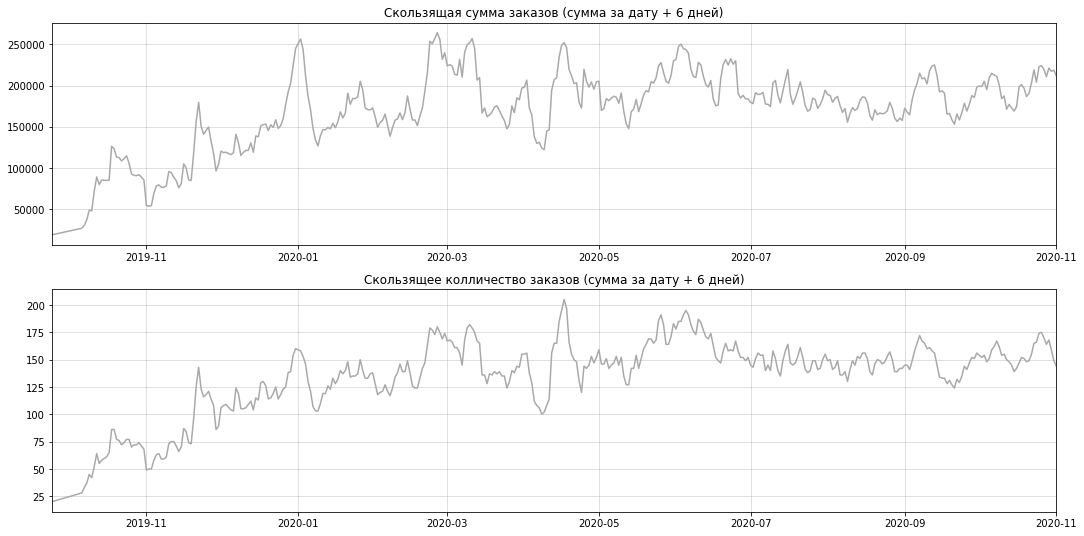

In [22]:
plot_weekly_sums('2019-09-24','2020-11-01')
#Код, строящий графики в конце блокнота, чтобы не мешать тут

In [23]:
grouped_weekly_sums

,Номер чека,"Сумма без скидки, р.",Чеков
Учетный день,,,
2019-09-24,578092.0,18987.0,20.0
2019-10-06,888170.0,26964.0,28.0
2019-10-07,1066524.0,30461.0,33.0
2019-10-08,1210938.0,37126.0,37.0
2019-10-09,1493326.0,49028.0,45.0
...,...,...,...
2020-10-29,12441420.0,221221.0,168.0
2020-10-30,11804194.0,217267.0,159.0
2020-10-31,11080308.0,218727.0,149.0


In [24]:
grouped_weekly_sums = grouped_weekly_sums.reset_index() #вернем даты из индекса в столбец

In [25]:
#Известно, что начиная с 2020г. учет точно велся корректно
#Найдем неделю в 2020г. с минимальной выручкой
grouped_weekly_sums['Сумма без скидки, р.'].loc[grouped_weekly_sums['Учетный день'] >= '2020-01-01'].min()

122380.0

In [26]:
grouped_weekly_sums = grouped_weekly_sums.groupby(by='Учетный день').mean()

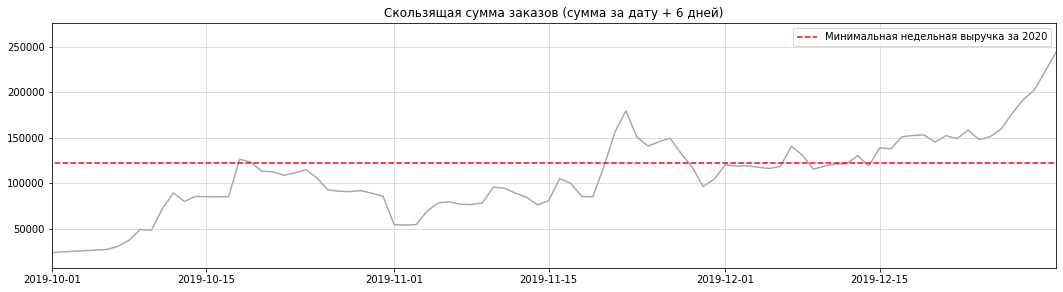

In [27]:
#Тот же график, первые три месяца
plot_weekly_sums_search_a_start_day('2019-10-1','2019-12-31')

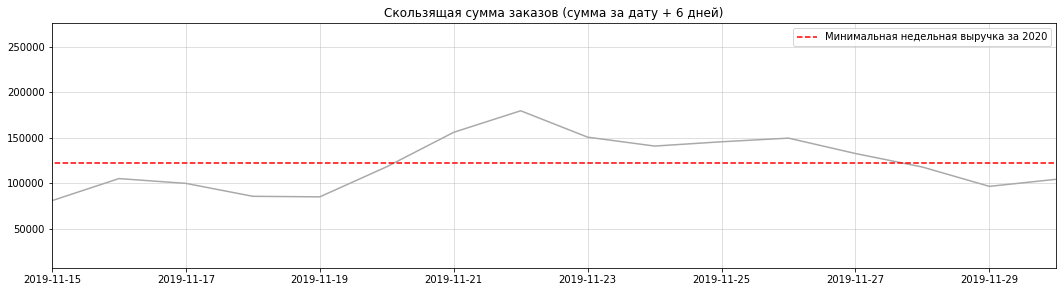

In [28]:
#Тот же график, вторая половина ноября
plot_weekly_sums_search_a_start_day('2019-11-15','2019-11-30')

Глядя на график, дальше будем считать, что заказы вносились в полном объеме начиная с 2019-11-20

In [29]:
df = df[df['Учетный день'] >= '2019-11-20']

In [30]:
#Добавим новый признак - день недели заказа
df['День недели'] = df['Учетный день'].dt.weekday_name
df[:200:10]

,Учетный день,Номер чека,"Сумма без скидки, р.",Чеков,День недели
459,2019-11-20,38930.0,2910.0,1,Wednesday
469,2019-11-20,38980.0,750.0,1,Wednesday
479,2019-11-20,39038.0,1160.0,1,Wednesday
489,2019-11-21,39073.0,810.0,1,Thursday
499,2019-11-21,39133.0,770.0,1,Thursday
509,2019-11-21,39167.0,1995.0,1,Thursday
519,2019-11-22,39206.0,1996.0,1,Friday
529,2019-11-22,39240.0,650.0,1,Friday
539,2019-11-22,39290.0,2760.0,1,Friday
549,2019-11-23,39394.0,575.0,1,Saturday


In [31]:
df = df.drop(columns=['Чеков', 'Номер чека']) #Столбцы 'Чеков' и 'Номер чека' нам тоже дальше не понадобится
df

,Учетный день,"Сумма без скидки, р.",День недели
459,2019-11-20,2910.0,Wednesday
460,2019-11-20,845.0,Wednesday
461,2019-11-20,500.0,Wednesday
462,2019-11-20,1185.0,Wednesday
463,2019-11-20,640.0,Wednesday
...,...,...,...
7683,2020-11-02,2680.0,Monday
7684,2020-11-02,1315.0,Monday
7685,2020-11-02,1446.5,Monday
7686,2020-11-02,1130.0,Monday


In [32]:
df.describe()
#Данные обработаны и готовы к дальнейшему расчету

,"Сумма без скидки, р."
count,7229.000000
mean,1270.126816
std,916.310665
min,500.000000
25%,735.000000
50%,1045.000000
75%,1507.000000
max,27200.000000


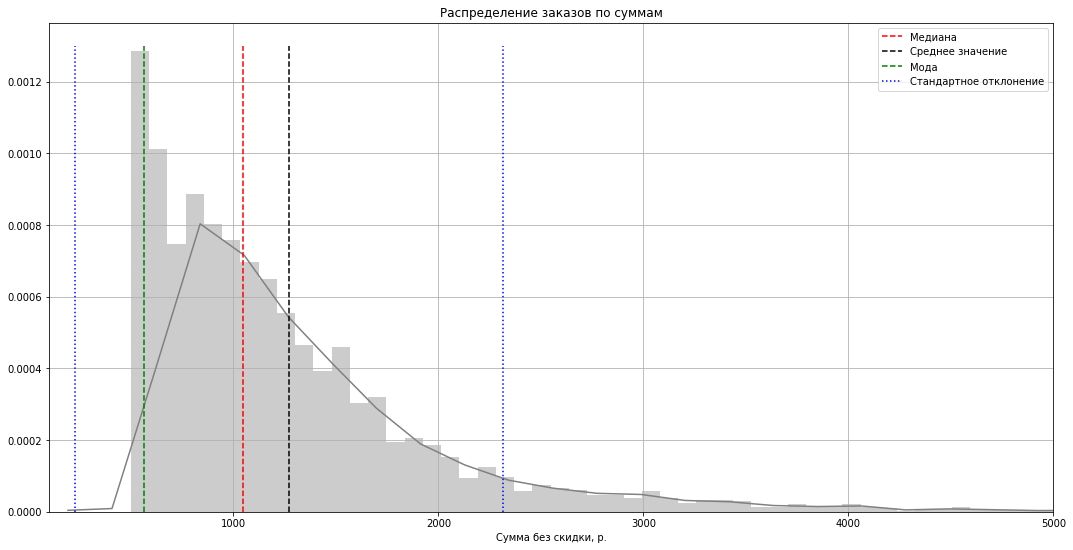

In [236]:
plot_distribution_checks()

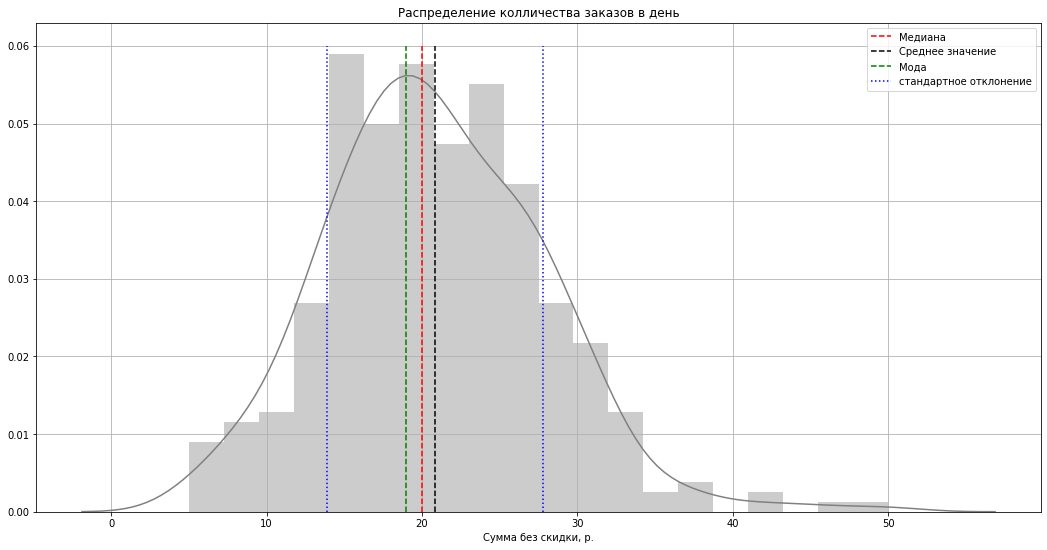

In [227]:
plot_distribution_orders()

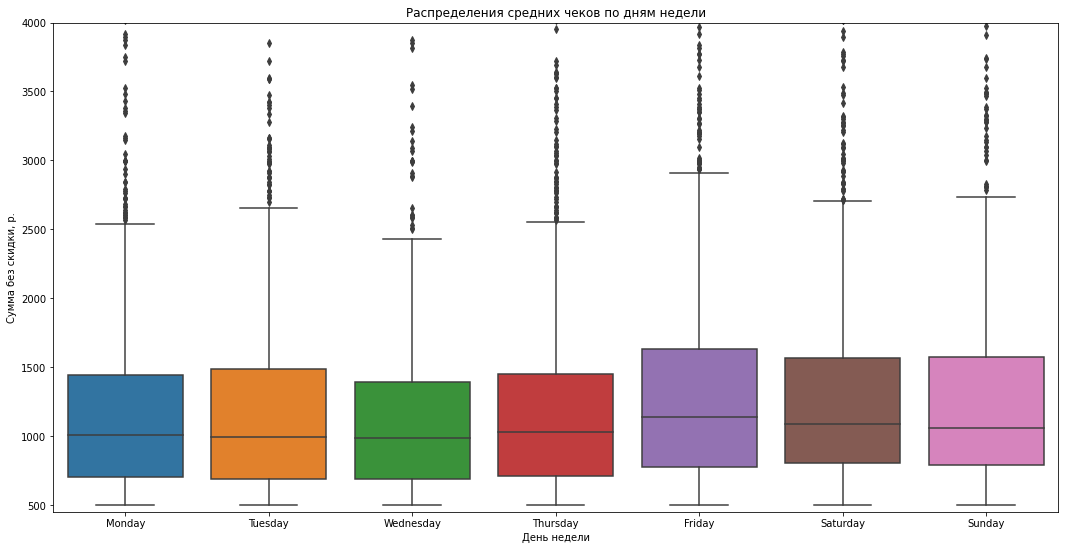

In [199]:
plot_boxplots()

In [47]:
df

,Учетный день,"Сумма без скидки, р.",День недели
459,2019-11-20,2910.0,Wednesday
460,2019-11-20,845.0,Wednesday
461,2019-11-20,500.0,Wednesday
462,2019-11-20,1185.0,Wednesday
463,2019-11-20,640.0,Wednesday
...,...,...,...
7683,2020-11-02,2680.0,Monday
7684,2020-11-02,1315.0,Monday
7685,2020-11-02,1446.5,Monday
7686,2020-11-02,1130.0,Monday


### Дисперсионный анализ ###

Ниже будет выполнен дисперсионный анализ значения среднего чека.
Цель анализа - оценить значимость статистичеких различий среднего чека заказа, от дня недели.

Нулевая гипотеза $H_0$: $\mu = \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5 = \mu_6 = \mu_7$  
т.е. значение среднего чека не зависит от дня недели  
Альтернативная гипотеза $H$: $\mu \neq \mu_1 ...  \neq \mu_n$  
т.е. значения среднего чека в разные дни недели имеют значимые статистические отличия 

Определим средние значения переменной по дням недели:

$$\overline{y}_{i} = \frac{1}{n_i}\sum\limits_{j=1}^{n_i}y_{ij}$$

In [33]:
days_df = df.groupby(by='День недели').sum()
days_df['Колличество чеков'] = df.groupby(by='День недели').count()['Учетный день']
days_df['Средний чек, р'] = df.groupby(by='День недели').mean()
days_df = days_df.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
days_df

,"Сумма без скидки, р.",Колличество чеков,"Средний чек, р"
День недели,,,
Monday,1068882.00,897,1191.618729
Tuesday,1091517.25,897,1216.853122
Wednesday,1121837.00,976,1149.423156
Thursday,1378656.00,1103,1249.914778
Friday,1831976.50,1290,1420.136822
Saturday,1440086.50,1104,1304.426178
Sunday,1248791.50,962,1298.120062


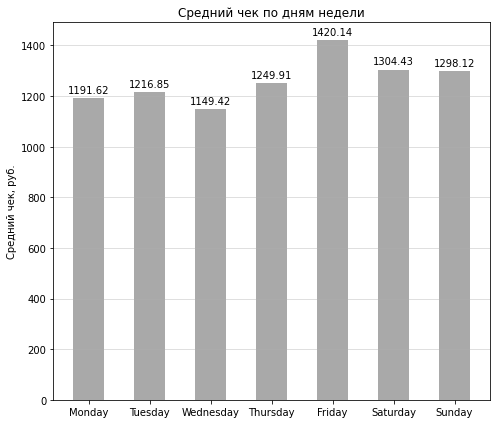

In [34]:
plot_weekly_means()

Средний чек отличается по дням недели, установим статистическую значимость этого различия  
Для этого определим среднее значение по всем записям:

$$\overline{Y} = \frac{1}{n}\sum\limits_{i=1}^{k}\sum\limits_{j=1}^{n_i}y_{ij} = \frac{1}{n}\sum\limits_{i=1}^{k}\overline{y}_{i}n_{i}$$

In [35]:
total_mean = df['Сумма без скидки, р.'].mean()
total_mean

1270.126815603818

Вычислим сумму квадратов отклонений от общего среднего

$$S^2 = \sum\limits_{i=1}^{k}\sum\limits_{j=1}^{n_i}({y}_{ij} - \overline{Y})^2$$

In [36]:
S2 = np.sum((df['Сумма без скидки, р.'] - total_mean)**2)
S2

6068811196.922096

Вычислим сумму квадратов отклонений среднегрупповых от общего среднего

$$S_F^2 = \sum\limits_{i=1}^{k}(\overline{y}_i - \overline{Y})^2n_i$$

In [37]:
S2_f = np.sum(((days_df['Средний чек, р'] - total_mean)**2)*days_df['Колличество чеков'])
S2_f

53826267.29464896

Вычислим остаточную сумму отклонений 

$$S_{ост}^{2} = \sum\limits_{i=1}^{k}\sum\limits_{j=1}^{n_i}(y_{ij} - \overline{y}_i)^2$$

In [38]:
S2_res = []
for day in days_df.index.to_list():
    S2_res.append(np.sum((df[df['День недели'] == day]['Сумма без скидки, р.'] - df[df['День недели'] == day]['Сумма без скидки, р.'].mean())**2))

S2_res = np.sum(S2_res)
S2_res

6014984929.627446

Проверим верность равенства $S^2 = S_F^2 + S_{ост}^2$:

In [39]:
round(S2, 2) == round(S2_f + S2_res, 2)

True

Вычислим общую:
    
$$\sigma_{общ}^{2} = \frac{S^2}{n - 1} = \frac{1}{n-1}\sum\limits_{i=1}^{k}\sum\limits_{j=1}^{n_i}(y_{ij} - \overline{Y})^2$$

факторную:

$$\sigma_{F}^{2} = \frac{S_{F}^{2}}{k-1} = \frac{1}{k-1}\sum\limits_{i=1}^{k}(\overline{y}_i - \overline{Y})^{2}n_i$$

и остаточную дисперсию:

$$\sigma_{ост}^{2} = \frac{S_{ост}^{2}}{n - k} = \frac{1}{n - k}\sum\limits_{i=1}^{k}\sum\limits_{j=1}^{n_i}(y_{ij} - \overline{y}_i)^2$$

In [41]:
sigma2_general = S2/(len(df)-1)
sigma2_f = S2_f/(7-1)
sigma2_res = S2_res/(len(df) - 7)

print('sigma2_general = {:.2f}'.format(sigma2_general))
print('sigma2_f       = {:.2f}'.format(sigma2_f))
print('sigma2_res     = {:.2f}'.format(sigma2_res))

sigma2_general = 839625.23
sigma2_f       = 8971044.55
sigma2_res     = 832869.69


Вычислим наблюдаемое значение критерия Фишера

$$F_H = \frac{\sigma_{F}^{2}}{\sigma_{ост}^{2}}$$

In [42]:
F_h = sigma2_f/sigma2_res
F_h

10.771246227822553

Зададим уровень значимости $\alpha = 0.05$,

k = 7,    
n = 7229  
$df_{межд} = k - 1 = 7 - 1 = 6$,   
$df_{внутр} = n - k = 7229 - 7 = 7222 > 1000 \Rightarrow df_{внутр} = \infty$

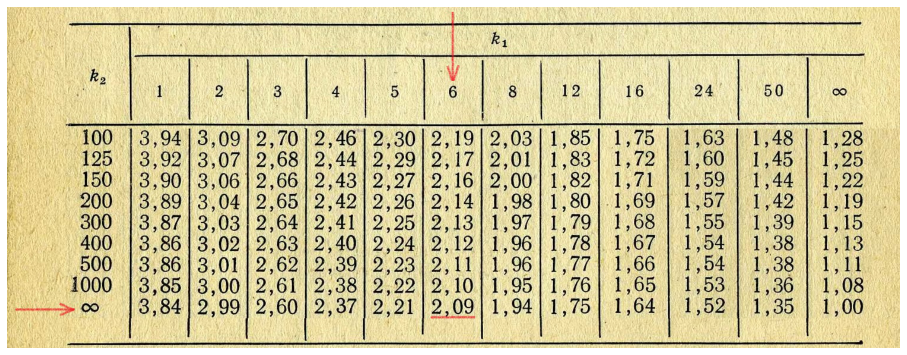

In [175]:
show_F()

In [284]:
stats.f.ppf(0.95, 6, 7222) #Табличное значение критерия Фишера из библиотеки ScyPy

2.0998465120540155

Тогда табличное значение F для заданного уровня значимости и колличества степеней свободы:
$F_{крит} = 2.09$

$$F_H > F_{крит}$$
$$10.77 > 2.09$$ 

#### Следовательно, гипотеза $H_0$ не может быть принята, т.к. средний чек статистически значимо отличается по дням недели

In [44]:
#Проверим полученное значение с помощью функции модуля scipy
days = days_df.index.to_list()

monday = df[df['День недели'] == days[0]]['Сумма без скидки, р.']
tuesday = df[df['День недели'] == days[1]]['Сумма без скидки, р.']
wednesday = df[df['День недели'] == days[2]]['Сумма без скидки, р.']
thursday = df[df['День недели'] == days[3]]['Сумма без скидки, р.']
friday = df[df['День недели'] == days[4]]['Сумма без скидки, р.']
saturday = df[df['День недели'] == days[5]]['Сумма без скидки, р.']
sunday = df[df['День недели'] == days[6]]['Сумма без скидки, р.']

stats.f_oneway(monday, tuesday, wednesday, thursday, friday, saturday, sunday)
#Значения совпали

F_onewayResult(statistic=10.771246227822537, pvalue=5.8339656639218495e-12)

#### Выясним между какими именно днями имеются статистические различия.   
Для этого проведем post hoc тесты, сравнивая попарно данные по дням недели по критерию Тьюки.  
Всего следует выполнить  $\frac{7!}{2!(7-2)!} = 21$ сравнение  
Сгрупируем данные по дню недели и отсортируем по значению среднего чека, чтобы определить, в каком порядке сравнивать

In [247]:
days_df.sort_values(by=['Средний чек, р'], ascending=False)

,"Сумма без скидки, р.",Колличество чеков,"Средний чек, р"
День недели,,,
Friday,1831976.50,1290,1420.136822
Saturday,1440086.50,1104,1304.426178
Sunday,1248791.50,962,1298.120062
Thursday,1378656.00,1103,1249.914778
Tuesday,1091517.25,897,1216.853122
Monday,1068882.00,897,1191.618729
Wednesday,1121837.00,976,1149.423156


Сравнивать будем в таком порядке, что сначала будут сравниваться день с наибольшим средним и день с наименьшим средним и далее и далее день с наибольшим средним будет сравниваться с днями с меньшими средними в порядке возрастания их среднего, а после этого будет выбран следующий по величине среднего чека день и он будет сравниваться с днями с меньшими средними в порядке их возрастания.  

Чтобы выполнить указанное сравнение необходимо вычислить значение критерия:

$$q = \frac{\overline{y}_b - \overline{y}_a}{SE}$$

при этом стандартную ошибку следует вычислить по формуле:

$$SE= \sqrt{\frac{\sigma_{ост}^{2}}{2}(\frac{1}{n_a} + \frac{1}{n_b})}$$

где:  
$\overline{y}_b, \overline{y}_a$ - средние значения в группах,  
$\sigma_{ост}^{2} = 832869.69$ - значение остаточной дисперсии, найденное в ходе дисперсионного анализа   
$n_a, n_b$ - колличество наблюдений в граппах а и b

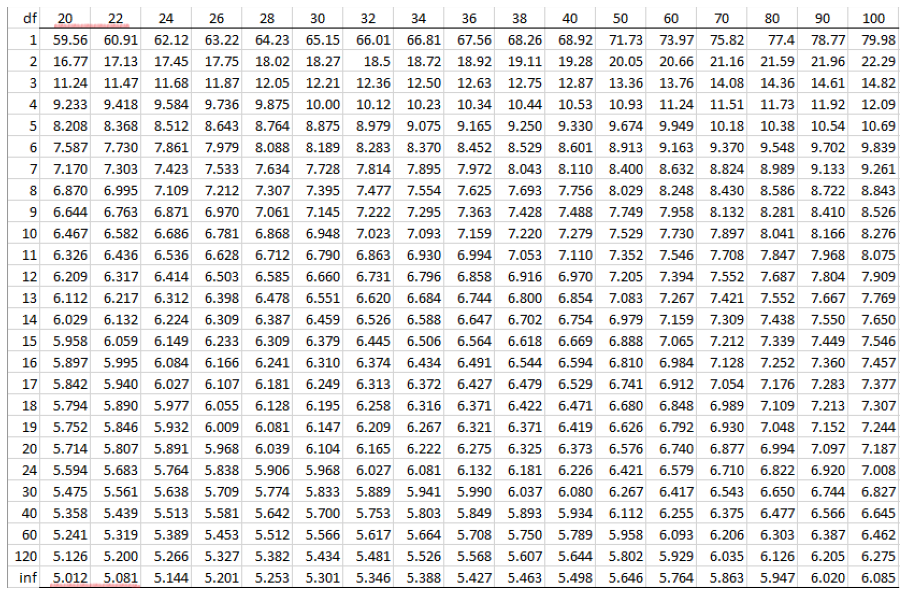

In [294]:
show_q()
#Источник таблицы: https://www.real-statistics.com/statistics-tables/studentized-range-q-table/

Определим критическое значение $q_кр$ по таблице выше:  
число сравнений - 21,  
колличество измерений в группах - 1031 (в среднем)  
уровень значимости - 0.05 (односторонний критерий)

Тогда $q_{кр}$ по нижней строке, среднее между 22 и 24 будет $q_{кр} = \frac{5.012+5.081}{2} = 5.047$

In [351]:
def calculate_k_Tukey(day_a, day_b):
    n_a, n_b = days_df.loc[day_a]['Колличество чеков'], days_df.loc[day_b]['Колличество чеков']
    se=((sigma2_res/2)*(1/n_a + 1/n_b))*0.5
    q = (days_df.loc[day_b]['Средний чек, р'] - days_df.loc[day_a]['Средний чек, р'])/se
    HSD = se*q
    q_0 = 5.047
    HSD_cr = q_0*se
    print('{:^10}-{:^10}, q={:.2f}, HSD наблюдаемый = {:.2f}, HSD критический = {:.2f}'.format(day_a, day_b, q, HSD, HSD_cr))

In [352]:
#Проведем все сравнения
list_1 = days_df.sort_values(by=['Средний чек, р'], ascending=False).index.to_list()
list_2 = days_df.sort_values(by=['Средний чек, р'], ascending=True).index.to_list()
for i, day_a in enumerate(list_1):
    #print(i, day_a)
    for day_b in list_2[:len(list_2)-i-1]:
        calculate_k_Tukey(day_a, day_b)

  Friday  -Wednesday , q=-0.72, HSD наблюдаемый = -270.71, HSD критический = 1891.34
  Friday  -  Monday  , q=-0.58, HSD наблюдаемый = -228.52, HSD критический = 1986.17
  Friday  - Tuesday  , q=-0.52, HSD наблюдаемый = -203.28, HSD критический = 1986.17
  Friday  - Thursday , q=-0.49, HSD наблюдаемый = -170.22, HSD критический = 1767.37
  Friday  -  Sunday  , q=-0.32, HSD наблюдаемый = -122.02, HSD критический = 1907.01
  Friday  - Saturday , q=-0.33, HSD наблюдаемый = -115.71, HSD критический = 1766.51
 Saturday -Wednesday , q=-0.39, HSD наблюдаемый = -155.00, HSD критический = 2028.59
 Saturday -  Monday  , q=-0.27, HSD наблюдаемый = -112.81, HSD критический = 2123.42
 Saturday - Tuesday  , q=-0.21, HSD наблюдаемый = -87.57, HSD критический = 2123.42
 Saturday - Thursday , q=-0.14, HSD наблюдаемый = -54.51, HSD критический = 1904.62
 Saturday -  Sunday  , q=-0.02, HSD наблюдаемый = -6.31, HSD критический = 2044.26
  Sunday  -Wednesday , q=-0.35, HSD наблюдаемый = -148.70, HSD критич

In [244]:
#Продублируем расчеты по poct-hoc тестам с помощью модуля statmodels
MultiComp = MultiComparison(df['Сумма без скидки, р.'], df['День недели'])
print(MultiComp.tukeyhsd().summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1    group2   meandiff p-adj    lower     upper   reject
--------------------------------------------------------------
  Friday    Monday -228.5181  0.001 -345.5257 -111.5104   True
  Friday  Saturday -115.7106 0.0327 -226.0584   -5.3629   True
  Friday    Sunday -122.0168 0.0283  -236.669   -7.3645   True
  Friday  Thursday  -170.222  0.001 -280.5968  -59.8473   True
  Friday   Tuesday -203.2837  0.001 -320.2913  -86.2761   True
  Friday Wednesday -270.7137  0.001 -384.8939 -156.5334   True
  Monday  Saturday  112.8074 0.0867   -8.1754  233.7903  False
  Monday    Sunday  106.5013 0.1542  -18.4201  231.4227  False
  Monday  Thursday    58.296 0.7641  -62.7114  179.3035  False
  Monday   Tuesday   25.2344    0.9 -101.8522   152.321  False
  Monday Wednesday  -42.1956    0.9 -166.6839   82.2928  False
Saturday    Sunday   -6.3061    0.9 -125.0125  112.4002  False
Saturday  Thursday  -54.5114 0.7745 -169.0917   60.0689

#### Значения наблюдаемого критерия сошлись, значит он рассчитан верно.
В расчете, полученном с помощью модуля statmodels результаты интерпритированы, крайний правый столбец указывает, следует ли считать различия в двух групах статистически значимыми

Результаты poct hoc сравнений указывают на наличие статистически значимых различий в величине пятничного среднего чека, относительно всех остальных дней недели, кроме этого были обнаружены значимые различия субботы со средой и воскресения со средой по этой же величине. Из полученных результатов следует, что предположение о том, что средние чеки отличаются по дням недели оказалось верным.


#### Вопросы по курсовому:
1. В процессе выполнения я не до конца понял методику сравнений по критерию Тьюки. Величины наблюдаемых значений критерия сошлись для расчета "вручную" и спомощью модуля statmodels, но что с этой величиной дальше делать и как её интерпритировать я так и не понял. Я пытался вычислить критическое значения критерия, но, кажется, оно не верно. В таблице результатов, полученных спомощью statmodels есть значение p_value, и отклонены только те гипотезы, для которых p_value < 0.05, но в источниках, из которых я брал расчет по критерию Тьюки результаты предполагалось сравнивать по значениям q, либо по HSD. В итоге что с чем сравнивать, чтобы верно все интерпритировать при расчете "вручную" я так и не смог разобраться

2. В процессе работы над проектом я сначала все предобработал и посчитал, а только потом решил построить графики, из-за чего я просмотрел, что распределение суммы заказов сильно отличается от нормального. Верно ли я понимаю, что для таких данных вообще некорректно выполнять дисперсионный анализ? Вот в этой статье автор указывает на то, что дисперсионный анализ устойчив к нарушению условий нормальности, но я не уверен, можно ли ему доверять:
https://habr.com/ru/post/304528/
Как поступать на практике, если очевидно, что распределение не совсем нормальное (например как в данном случае - похожее на нормальное, но усеченное с одной стороны), а дисперсионный анализ провести надо? Нужно ли специально убирать все наблюдения, не попавшие в интервал $\pm3\sigma$, как "выбросы", чтобы сделать данные более "нормальными"?
3. Еще один вопрос про область применения. Верно ли я понимаю, что некорректно было начинать post hoc тесты по критерию Тьюки, до того как я не убедился в равенстве дисперсий (в ячейке ниже посчитаны дисперсии по дням недели и они отличаются местами на порядок)? Как следует подготавливать данные, чтобы пройти по этому условию?

Спасибо за уделенное время!)

In [354]:
df.groupby(by='День недели').var()

,"Сумма без скидки, р."
День недели,
Friday,1.879581e+06
Monday,5.387867e+05
Saturday,6.487858e+05
Sunday,6.507149e+05
Thursday,7.232163e+05
Tuesday,6.183918e+05
Wednesday,4.281451e+05


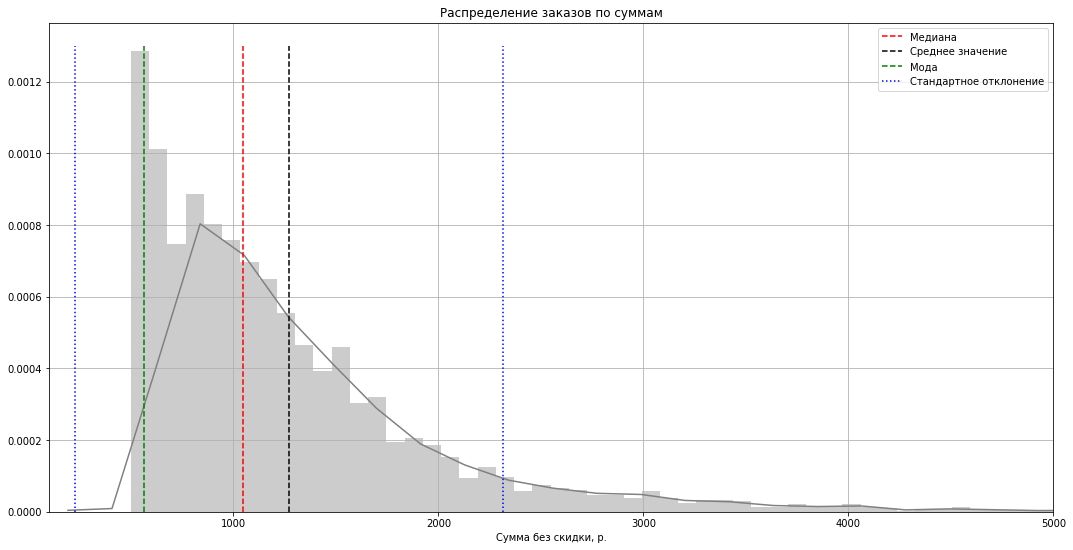

In [353]:
plot_distribution_checks()

In [170]:
#Ниже код, строящий графики

In [21]:
def plot_weekly_sums_search_a_start_day(a, b):
    fig = plt.figure(figsize=(18, 4.5))

    ax1 = fig.add_subplot(111)
    ax1.set_title('Скользящая сумма заказов (сумма за дату + 6 дней)')
    ax1.plot(grouped_weekly_sums['Сумма без скидки, р.'], color='darkgray')
    
    x = grouped_weekly_sums.index.to_list()
    y = [122280 for i in x]
    
    ax1.plot(x, y, color='red', linestyle = 'dashed', label='Минимальная недельная выручка за 2020')
    ax1.legend()
    ax1.grid(alpha=0.5)
    ax1.set_xlim([a, b])
    
    

    plt.show()

In [20]:
def plot_weekly_means():
    labels = days_df.index.to_list()
    means = days_df['Средний чек, р'].to_list()

    width = 0.5
    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects = ax.bar(x, means, width, color='darkgray')

    ax.set_ylabel('Средний чек, руб.')
    ax.set_title('Средний чек по дням недели')
    ax.grid(which='both', axis='y', alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects:  
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

In [19]:
def plot_weekly_sums(a, b):
    fig = plt.figure(figsize=(18, 9))

    ax1 = fig.add_subplot(211)
    ax1.set_title('Скользящая сумма заказов (сумма за дату + 6 дней)')
    ax1.plot(grouped_weekly_sums['Сумма без скидки, р.'], color='darkgray')
    ax1.grid(alpha=0.5)
    ax1.set_xlim([a, b])
    

    ax2 = fig.add_subplot(212)
    ax2.set_title('Скользящее колличество заказов (сумма за дату + 6 дней)')
    ax2.plot(grouped_weekly_sums['Чеков'], color='darkgray')
    ax2.grid(alpha=0.5)
    ax2.set_xlim([a, b])

    plt.show()

In [88]:
def plot_distribution():
    plt.figure(figsize=(18, 9))
    plt.hist(x=df['Сумма без скидки, р.'], bins=500, color='gray')

    y = np.linspace(0, 520, 2)
    plt.plot([df['Сумма без скидки, р.'].median()]*2, y, color='red', linestyle='dashed', label='Медиана')
    plt.plot([df['Сумма без скидки, р.'].std()]*2, y, color='black', linestyle='dashed', label='Среднее значение')
    plt.plot([df['Сумма без скидки, р.'].mode()]*2, y, color='green', linestyle='dashed', label='Мода')
    plt.xlim([250, 5000])
    plt.grid()
    plt.title('Распределение заказов по суммам')
    plt.legend()
    plt.show()

In [235]:
def plot_distribution_checks():
    plt.figure(figsize=(18, 9))
    sns.distplot(df['Сумма без скидки, р.'], bins=300, color='gray')

    y = np.linspace(0, 0.0013, 2)
    plt.plot([df['Сумма без скидки, р.'].median()]*2, y, color='red', linestyle='dashed', label='Медиана')
    plt.plot([df['Сумма без скидки, р.'].mean()]*2, y, color='black', linestyle='dashed', label='Среднее значение')
    plt.plot([df['Сумма без скидки, р.'].mode()]*2, y, color='green', linestyle='dashed', label='Мода')
    
    std_a = df['Сумма без скидки, р.'].mean() - df['Сумма без скидки, р.'].median()
    std_b = df['Сумма без скидки, р.'].mean() + df['Сумма без скидки, р.'].median()
    plt.plot([std_a]*2, y, color='blue', linestyle='dotted', label='Cтандартное отклонение')
    plt.plot([std_b]*2, y, color='blue', linestyle='dotted', )
    
    plt.xlim([100, 5000])
    plt.grid()
    plt.title('Распределение заказов по суммам')
    plt.legend()
    plt.show()

In [230]:
def plot_distribution_orders():
    plt.figure(figsize=(18, 9))
    sns.distplot(df.groupby(by='Учетный день').count()['Сумма без скидки, р.'], bins=20, color='gray')

    y = np.linspace(0, 0.06, 2)
    plt.plot([df.groupby(by='Учетный день').count()['День недели'].median()]*2, y, color='red', linestyle='dashed', label='Медиана')
    plt.plot([df.groupby(by='Учетный день').count()['День недели'].mean()]*2, y, color='black', linestyle='dashed', label='Среднее значение')
    plt.plot([df.groupby(by='Учетный день').count()['День недели'].mode()]*2, y, color='green', linestyle='dashed', label='Мода')
    
    std_a = df.groupby(by='Учетный день').count()['День недели'].mean() + df.groupby(by='Учетный день').count()['День недели'].std()
    std_b = df.groupby(by='Учетный день').count()['День недели'].mean() - df.groupby(by='Учетный день').count()['День недели'].std()
    plt.plot([std_a]*2, y, color='blue', linestyle='dotted', label='Cтандартное отклонение')
    plt.plot([std_b]*2, y, color='blue', linestyle='dotted', )
    plt.grid()
    plt.title('Распределение колличества заказов в день')
    plt.legend()
    plt.show()

In [174]:
def show_F():
    image_path = 'K_Fisher.jpg'
    image = img.imread(image_path)
    
    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [292]:
def show_q():
    image_path = 'studentized_q.png'
    image = img.imread(image_path)
    
    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [198]:
def plot_boxplots():
    plt.figure(figsize=(18,9))
    sns.boxplot(df['День недели'], df['Сумма без скидки, р.'] , order=days_df.index.to_list(), orient='v')
    plt.title('Распределения средних чеков по дням недели')
    plt.ylim([450, 4000])
    plt.show()